<a href="https://colab.research.google.com/github/AyomiUpeksha/Hands-On-Practices-Python-R-/blob/main/Binary_Cliassifier_with_MNIST_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


## **Stochastic Gradient Descent (SGD Classifier)**

In this section, we will use the MNIST dataset to train a classifier and understand the results of the model.


MNIST dataset is a set of 70,000 small images of digits handwritten by high school students and employees of the US Census Bureau. Each image is labeled with the digit it represents. This set has been studied so much that it is often called the “Hello World” of Machine Learning: whenever people come up with a new classification algorithm, they are curious to see how it will perform on MNIST. 

### **1. Getting Started with the MNIST Dataset**

Scikit-Learn provides many helper functions to download popular datasets. MNIST is one of them. The following code fetches the MNIST dataset:


In [ ]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'feature_names', 'target_names', 'DESCR', 'details', 'categories', 'url'])

Let's take a look at the data:

In [ ]:
X,y =mnist["data"],mnist["target"]
X.shape

(70000, 784)

In [ ]:
y.shape

(70000,)

There are 70,000 images, and each image has 784 features. This is because each image is 28×28 pixels, and each feature simply represents one pixel’s intensity, from 0 (white) to 255 (black). 

Let’s take a peek at one digit from the dataset. All you need to do is grab an instance’s feature vector, reshape it to a 28×28 array, and display it using Matplotlib’s imshow() function:

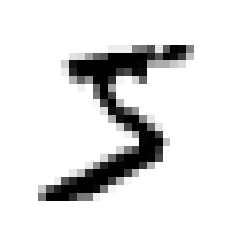

In [ ]:
import matplotlib as mpl
import matplotlib.pyplot as plt
some_digit = X[0]
some_digit_image = some_digit.reshape(28,28)
plt.imshow(some_digit_image,cmap = mpl.cm.binary,interpolation="nearest")
plt.axis("off")
plt.show()

This looks like a 5, and indeed that’s what the label tells us:

In [ ]:
y[0]

'5'

Note that the label is a string. We prefer numbers, so let’s cast y to integers:

In [ ]:
import numpy as np
y = y.astype(np.uint8)

The MNIST dataset is actually already split into a training set (the first 60,000 images) and a test set (the last 10,000 images). Therefore, let's move ahead and separate the training and testing sets:

In [ ]:
X_train, X_test, y_train, y_test = X[:60000],X[60000:],y[:60000],y[60000:]

Note: The training set is already shuffled for us, which is good as this guarantees that all cross-validation folds will be similar (you don’t want one fold to be missing some digits). Moreover, some learning algorithms are sensitive to the order of the training instances, and they perform poorly if they get many similar instances in a row. Shuffling the dataset ensures that this won’t happen.

### **2. Training a Binary Classifier**

Let’s simplify the problem for now and only try to identify one digit—for example, the number 5. This “5-detector” will be an example of a binary classifier, capable of distinguishing between just two classes, 5 and not-5. 

Let’s create the target vectors for this classification task:

In [ ]:
y_train_5 = (y_train ==5)# true for all 5 s ,false for others
y_test_5 = (y_test ==5)

Let's use the Stochastic Gradient Descent (SGD) classifier, using Scikit-Learn’s SGDClassifier class. This classifier has the advantage of being capable of handling very large datasets efficiently. This is in part because SGD deals with training instances independently, one at a time (which also makes SGD well suited for online learning), as we will see later. 

Let’s create an SGDClassifier and train it on the whole training set:

In [ ]:
from sklearn.linear_model import SGDClassifier
sgd_clf = SGDClassifier(random_state = 42)
sgd_clf.fit(X_train,y_train_5)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=42, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

Now you can use it to detect images of the number 5:

In [ ]:
sgd_clf.predict([some_digit])

array([ True])

### **3. Performance Measures**

#### Measuring Accuracy Using Cross-Validation
Let’s use the cross_val_score() function to evaluate your SGDClassifier model using K-fold cross-validation, with three folds. K-fold cross- validation means splitting the training set into K-folds (in this case, three), then making predictions and evaluating them on each fold using a model trained on the remaining folds:

In [ ]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.95035, 0.96035, 0.9604 ])

Wow! Above 95% accuracy (ratio of correct predictions) on all cross-validation folds? This looks amazing, doesn’t it? Well, before you get too excited, let’s look at a very dumb classifier that just classifies every single image in the “not-5” class:

In [ ]:
from sklearn.base import BaseEstimator
import numpy as np
class Never5Classifier(BaseEstimator):
  def fit(self,X, y=None):
    pass
  def predict(self,X):
    return np.zeros((len(X),1),dtype=bool)

Let's find the accuracy of this dumb-classifier:

In [ ]:
never_5_clf =Never5Classifier()
cross_val_score(never_5_clf,X_train,y_train_5,cv=3, scoring="accuracy")

array([0.91125, 0.90855, 0.90915])

That’s right, it has over 90% accuracy! This is simply because only about 10% of the images are 5s, so if you always guess that an image is not a 5, you will be right about 90% of the time. 

This demonstrates why accuracy is generally not the preferred performance measure for classifiers, especially when you are dealing with skewed datasets (i.e., when some classes are much more frequent than others).

#### Confusion Matrix

A much better way to evaluate the performance of a classifier is to look at the confusion matrix. The general idea is to count the number of times instances of class A are classified as class B.

For example, to know the number of times the classifier confused images of 5s with 3s, you would look in the 5th row and 3rd column of the confusion matrix.

To compute the confusion matrix, you first need to have a set of predictions, so they can be compared to the actual targets. You could make predictions on the test set, but let’s keep it untouched for now.

In [ ]:
from sklearn.model_selection import cross_val_predict
y_train_pred = cross_val_predict(sgd_clf, X_train,y_train_5, cv =3)

Just like the cross_val_score() function, cross_val_predict() performs K-fold cross-validation, but instead of returning the evaluation scores, it returns the predictions made on each test fold. This means that you get a clean prediction for each instance in the training set (“clean” meaning that the prediction is made by a model that never saw the data during training).

Now you are ready to get the confusion matrix using the confusion_matrix() function. Just pass it the target classes (y_train_5) and the predicted classes (y_train_pred):

In [ ]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_5,y_train_pred)

array([[53892,   687],
       [ 1891,  3530]])

Each row in a confusion matrix represents an actual class, while each column repre‐ sents a predicted class. The first row of this matrix considers non-5 images (the nega‐ tive class): 53,057 of them were correctly classified as non-5s (they are called true negatives), while the remaining 1,522 were wrongly classified as 5s (false positives). The second row considers the images of 5s (the positive class): 1,325 were wrongly classified as non-5s (false negatives), while the remaining 4,096 were correctly classified as 5s (true positives). 

A perfect classifier would have only true positives and true negatives, so its confusion matrix would have nonzero values only on its main diagonal (top left to bottom right).

**Precision - the accuracy of the positive predictions**

Precision = TP / (TP + FP)

where, TP = number of true positives and FP = number of false positives

Precision is typically used along with another metric named **recall**, also called sensitivity or true positive rate.

**Recall - the ratio of positive instances that are correctly detected by the classifier**

Recall = TP / (TP + FN)

#### Precision and Recall

Scikit-Learn provides several functions to compute classifier metrics, including precision and recall:

In [ ]:
from sklearn.metrics import precision_score, recall_score
precision_score(y_train_5,y_train_pred)

0.8370879772350012

In [ ]:
recall_score(y_train_5,y_train_pred)

0.6511713705958311

Now, our classifier doesn't look that great, as when it looked like when we compared with its accuracy.

When it claims an image represents a 5, it is correct only 83.7% of the time. More‐ over, it only detects 65.1% of the 5s.

In [ ]:
from sklearn.metrics import precision_score, recall_score,f1_score
p=precision_score(y_train_5,y_train_pred)
p

0.8370879772350012

In [ ]:
r=recall_score(y_train_5,y_train_pred)
r

0.6511713705958311

In [ ]:
f1_score(y_train_5,y_train_pred)

0.7325171197343846

In [ ]:
f1=(2*p*r)/(p+r)
f1

0.7325171197343846